# Bloch Simulation (bSSFP)

This notebook aims to demonstrate the signal generated in a single voxel of tissue with a steady-state sequences in MRI, including transient state and steady state.

In [17]:
#Import Packages
import numpy as np
import cmath
from scipy import constants
import matplotlib.pyplot as plt

### 0. Functions: Rotation and Precession

In [18]:
#Rotation Matrices
def z_rot(phi): #Longitudinal Relaxation
    return np.array([[np.cos(phi),-np.sin(phi),0],
                     [np.sin(phi),np.cos(phi),0],
                     [0,0,1]])
def x_rot(phi): #Transverse Relaxation about the x axis
    return np.array([[1,0,0], 
                     [0,np.cos(phi),-np.sin(phi)],
                     [0,np.sin(phi),np.cos(phi)]])
def y_rot(phi): #Transverse Relaxation about the y axis
    return np.array([[np.cos(phi),0,np.sin(phi)],
                     [0,1,0],
                     [-np.sin(phi),0,np.cos(phi)]])
def th_rot(phi, theta): #Transverse Relaxation about an arbitrary transverse axis
    return np.matmul(np.matmul(z_rot(theta), x_rot(phi)), z_rot(-theta))

In [19]:
#Precession and Decay
# M = A * M + B
def free_precess(t,T1,T2,d_freq):
    theta = 2 * np.pi * d_freq * t
    e1 = np.exp(-t/T1)
    e2 = np.exp(-t/T2)
    A = np.array([[e2,0,0],
                  [0,e2,0],
                  [0,0,e1]])
    Afp = np.matmul(z_rot(theta), A)
    Bfp = np.array([[0],
                    [0],
                    [1-e1]])
    return Afp, Bfp

In [20]:
#Steady-state signal at TE
def sssignal(flip, T1, T2, TE, TR, df):
    
    #Find the matrices for precession, relaxation and decay over a single TR
    Atr, Btr = free_precess(TR, T1, T2, df)
    
    temp = np.eye(3)-np.matmul(Atr, y_rot(flip))
    Mss_1 = np.matmul(np.linalg.inv(temp), Btr)
    
    # Tipping the spin for the latest excitation
    M_exc = np.matmul(y_rot(flip), Mss_1)
    
    #finding the relevant matrices for the spin at TE
    Ate, Bte = free_precess(TE, T1, T2, df)
    
    Mss = np.matmul(Ate, M_exc) + Bte
    Msig = Mss[0] + 1j * Mss[1]
    
    return Mss, Msig

### 1. Tissue Properties & Scanner Parameters

In [21]:
#Tissue Properties
T1 = 1000/1000 #s
T2 = 80/1000 #s
PD = 1
OffRes = 0 #Hz

In [22]:
#Pulse Sequence Parameters
# TR = 0.01 #seconds
# TE = 0.005 #seconds
TR = 10/1000 #s
TE = 5/1000 #s
df = 0
flip = np.deg2rad(1) #flip angle (rad)

### 2. Signals over TRs

In [23]:
n_TRs = 200 #number of repetitions

M = np.array([[0],[0],[PD]]) #Magnetisation vector (x,y,z) - initial condition
M_signals = np.empty((3, n_TRs)) #Initialise array to store signals

Ate, Bte = free_precess(TE, T1, T2, df)

#loop over a number of TRs
for n in range(n_TRs):
#     M_signals[n] = Msig
    
    if n == 0:
        signal = M_signals[:,0]
    else:
        tipped_spin = np.reshape(np.matmul(th_rot(flip, np.deg2rad(60)), signal), (3, 1))
        M_signals[:,n] = np.reshape(np.matmul(Ate, tipped_spin) + Bte, (3,))
        signal = np.matmul(Ate, np.reshape(M_signals[:,n], (3,1))) + Bte

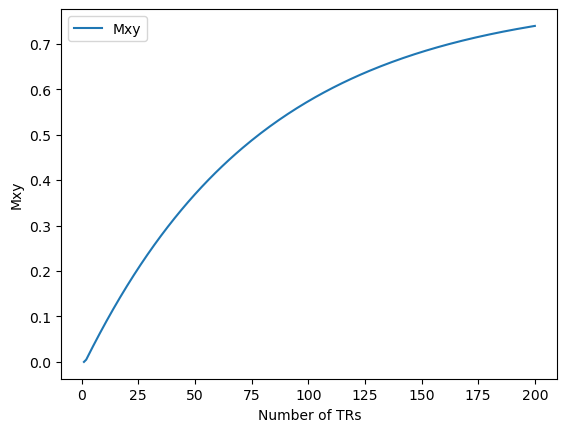

In [24]:
#plot signals
TRs = np.arange(1, n_TRs+1)
plt.figure()
plt.plot(TRs, M_signals[2, :], label = "Mxy")
plt.xlabel("Number of TRs")
plt.ylabel("Mxy")
plt.legend()

#order of magnitude - ~10% PD
#plot magnitude instead of real part
#change dir of tip 0-pi

### 3. Phase Cycling - Magnitude & Phase Plots

Text(0, 0.5, 'Phase')

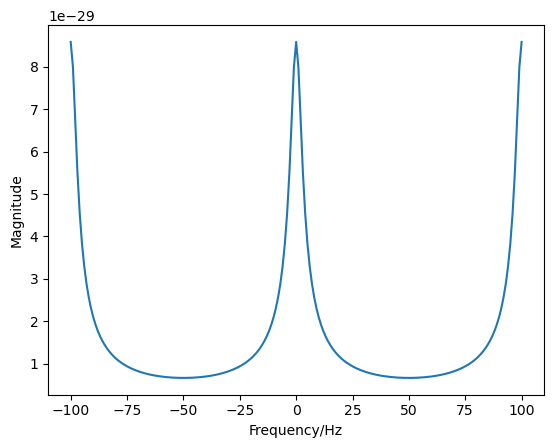

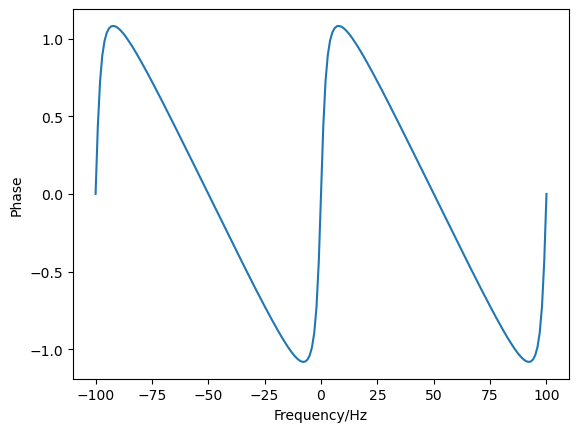

In [25]:
df_PC = np.linspace(-100,100,201)
TE_PC = 5 #try TE = 0, TR/2, TR
signals_PC = np.empty((len(df_PC), 3), dtype=complex) #initialise array to store signals

# for m in range(len(TE_PC)):
for k in range(len(df_PC)):
    Mss_PC, Msig_PC = sssignal(flip, T1, T2, TE_PC, TR, df_PC[k])
#     print (Msig)
    signals_PC[k,:] = Msig_PC 
    
#Plot Results
plt.figure()
plt.plot(df_PC, np.abs(signals_PC[:, 0]))
plt.xlabel("Frequency/Hz")
plt.ylabel("Magnitude")

plt.figure()
plt.plot(df_PC, np.angle(signals_PC[:, 0]))
plt.xlabel("Frequency/Hz")
plt.ylabel("Phase")


#FEMR




